# 1. Importing libraries

In [1]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Clusters and metrics
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer

# Clustering models
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# Custom functions and classes
# -----------------------------------------------------------------------
from src.preprocess import preprocess
from src.eda import plot_relation_tv
from src.circuit_clustering_model.clustering import *


# 2. Data loading

We loaded the original circuits dataset and the dataset with feature engineering. Both datasets are clean and free of duplicates.

In [28]:
df_original = pd.read_csv('../data/output/circuits_complete.csv', index_col=0)

df_original.head()

,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,straight_length,gear_changes,n_slow_corners,n_medium_corners,n_fast_corners,n_gear1_corners,n_gear2_corners,n_gear3_corners,n_gear4_corners,n_gear5_corners,n_gear6_corners,n_gear7_corners,n_gear8_corners
hockenheimring,71.767,320.0,4568.748333,17,209.960540,229.888136,1663.919441,40.0,3,9,5,0,1,3,1,3,5,3,1
nurburgring,85.269,318.0,5112.340000,15,173.563856,216.201705,2043.790918,50.0,5,7,3,0,0,4,3,3,1,2,1
portimao,77.968,314.0,4637.664722,15,188.740533,214.136223,1800.793691,40.0,4,5,6,0,0,4,2,1,4,4,0
sochi,101.993,291.0,5789.306111,18,172.024977,204.520095,1284.998104,64.0,5,8,5,0,3,7,2,1,1,3,1
istanbul,82.868,321.0,5253.130833,14,176.854350,228.286957,3877.396258,39.0,3,8,3,0,3,1,4,1,0,2,1


In [29]:
df_featured = pd.read_csv('../data/output/featured_circuits_complete.csv', index_col=0)

df_featured.head()

,max_speed,distance,avg_corner_speed,avg_speed,short_gear_corners_prop,long_gear_corners_prop,slow_corners_prop,medium_corners_prop,fast_corners_prop,straight_prop,gear_changes_per_km,n_corners_per_km
hockenheimring,320.0,4568.748333,209.960540,229.888136,0.294118,0.705882,0.176471,0.529412,0.294118,0.364196,8.755133,3.720932
nurburgring,318.0,5112.340000,173.563856,216.201705,0.466667,0.466667,0.333333,0.466667,0.200000,0.399776,9.780257,2.934077
portimao,314.0,4637.664722,188.740533,214.136223,0.400000,0.600000,0.266667,0.333333,0.400000,0.388298,8.625031,3.234386
sochi,291.0,5789.306111,172.024977,204.520095,0.666667,0.333333,0.277778,0.444444,0.277778,0.221961,11.054865,3.109181
istanbul,321.0,5253.130833,176.854350,228.286957,0.571429,0.285714,0.214286,0.571429,0.214286,0.738111,7.424144,2.665077


We will use the dataset with feature engineering for clustering since its variables can be more meaningful.

# 3. Preprocessing  

To carry out the preprocessing, we need to evaluate the following aspects:  

* Remove the columns we do not want to consider:
    - In this case, we do not need to remove any columns since the datasets are already prepared for preprocessing.  

* Select the encoding methods for categorical variables:
    - We do not have categorical variables, so we do not need to perform `encoding`.  

* Select the scaling method: 
    - Since we have very few outliers in our datasets and there are no extremely high values, we will use a `MinMax` scaler.


In [30]:
encoding_methods = {}
scaling = 'minmax'

df_encoded, df_scaled = preprocess(df_featured, encoding_methods, scaling)

# 4. Clustering

## 4.1 K-means

We have the following columns/features available:

- `max_speed`: The maximum speed reached on the circuit.

- `distance`: The total length of the circuit measured in kilometers.

- `avg_corner_speed`: The average speed of the car through the corners apex on the circuit.

- `avg_speed`: The overall average speed of the car over the entire circuit.

- `short_gear_corners_prop`: The proportion of corners on the track where cars need to use shorter gears (1 to 4).

- `long_gear_corners_prop`: The proportion of corners that require longer gears (5 to 8).

- `slow_corners_prop`: The percentage of corners on the circuit that are classified as slow (less than 120 kph).

- `medium_corners_prop`: The proportion of corners that are of medium speed (from 120 to 240 kph).

- `fast_corners_prop`: The percentage of corners on the track that are classified as fast (more than 240 kph).

- `straight_prop`: The proportion of the circuit that consists of straight sections (more than 500 m).

- `gear_changes_per_km`: The average number of gear shifts the car makes per kilometer on the circuit.

- `n_corners_per_km`: The number of corners per kilometer.

### Selection of Variables for Circuit Clustering

To perform an effective segmentation of the circuits, it is essential to choose variables that meaningfully represent their distinctive characteristics. In this case, we have selected `avg_speed` (average speed), `straight_prop` (proportion of straights), and `slow_corners_prop` (proportion of slow corners), as these variables capture key aspects of each circuit's layout.

Using a limited set of variables helps avoid issues related to high dimensionality, especially given that our dataset is not very large. Including too many variables could dilute the definition of the clusters and make segmentation less clear. However, in future iterations, we could test additional variables, and evaluate their impact on cluster cohesion using dimensionality reduction techniques like `PCA` or `feature importance` metrics.


In [203]:
cols = ['avg_speed', 'straight_prop', 'slow_corners_prop']

df_kmeans = df_scaled[cols]

We will initialize a `K-Means` model and use the `Silhouette Score` as a criterion to determine the optimal number of clusters. This approach allows us to assess which number of groups provides the best cohesion and separation within the data.


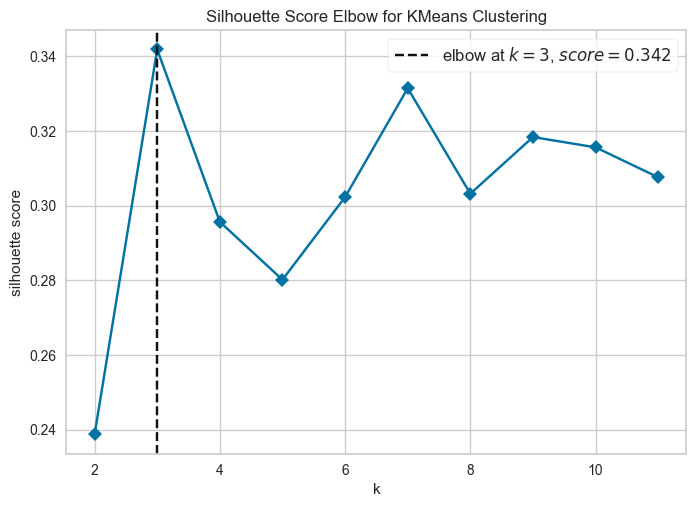

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [212]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 12), metric="silhouette", timings=False)
visualizer.fit(df_kmeans)
visualizer.show()

The `elbow metho` suggests that an appropriate number of clusters could be 3. However, Formula 1 circuits have significant differences, making a segmentation into only three groups too general. For this reason, we will select the next best option identified, which corresponds to `7 clusters`, allowing for a more detailed differentiation between the various types of circuits.

In [223]:
model_kmeans = KMeans(n_clusters=7, random_state=42)

km_fit = model_kmeans.fit(df_kmeans)
labels = km_fit.labels_

clustering_metrics(df_kmeans, labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.331412,0.688945,3
1,0.331412,0.688945,4
2,0.331412,0.688945,7
3,0.331412,0.688945,2
4,0.331412,0.688945,10
5,0.331412,0.688945,3
6,0.331412,0.688945,1


To validate our choice, we analyzed multiple feature combinations and different numbers of clusters, evaluating their quality using the following metrics:  
- `Silhouette Score`: 0.331412  
- `Davies-Bouldin Index`: 0.688945  

These values represent some of the best metrics obtained in our experiments, ensuring a balance between cohesion, separation, and interpretability. 

While we could optimize the metrics further with more clusters, we prioritize a segmentation that remains interpretable and meaningfully reflects circuit differences. For this reason, we selected 7 clusters as the best option.


In [224]:
# Add labels to dataframe
df_kmeans['cluster'] = km_fit.labels_

We can now analyze which circuits have been grouped into each cluster.

In [233]:
df_kmeans['cluster'].sort_values()

vegas             0
rodriguez         0
miami             0
hockenheimring    1
zandvoort         1
hungaroring       1
interlagos        1
nurburgring       2
shanghai          2
portimao          2
americas          2
marina_bay        2
baku              2
sochi             2
catalunya         3
silverstone       3
istanbul          4
yas_marina        4
monza             4
villeneuve        4
red_bull_ring     4
spa               4
ricard            4
suzuka            4
albert_park       4
bahrain           4
imola             5
losail            5
jeddah            5
monaco            6
Name: cluster, dtype: int32

In [254]:
import plotly.express as px
import plotly.graph_objects as go

In [266]:
col = "avg_speed"


def plot_clusters(df, col):

    # Get mean value by cluster
    df_group = df.groupby('cluster')[col].mean().reset_index()

    # Colors
    colors = px.colors.qualitative.Plotly

    # Create figure
    fig = go.Figure()

    # Add a bar for each cluster
    for i, row in df_group.iterrows():
        fig.add_trace(go.Bar(
            x=[f'Cluster {int(row["cluster"])}'],
            y=[row[col]],  
            name=f'Cluster {int(row["cluster"])}',  
            marker_color=colors[i % len(colors)]
        ))

    # Config
    fig.update_layout(
        title=f"Cluster Comparison - {col}",
        xaxis_title="Clusters",
        yaxis_title="Mean Value",
        template="plotly_dark",
        showlegend=True,
        legend_title=""
    )

    return fig


In [267]:
plot_clusters(df_kmeans, 'avg_speed')

Radar plot

In [274]:
def radar_plot(df, columns):

    # Get mean values for every column by cluster
    cluster_means = df.groupby('cluster')[columns].mean()

    # Close the radar
    cluster_means = pd.concat([cluster_means, cluster_means.iloc[:, 0:1]], axis=1)

    # Definir ángulos para el radar chart
    num_vars = len(columns)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Create figure
    fig = go.Figure()

    # Add each cluster
    for i, row in cluster_means.iterrows():
        fig.add_trace(go.Scatterpolar(
            r=row.values,
            theta=columns + [columns[0]],
            fill='toself',
            name=f'Cluster {i}',
            opacity=0.4
        ))

    # Config
    fig.update_layout(
        polar=dict(
            radialaxis=dict(visible=True)
        ),
        title="Cluster Profiles (Radar Chart)",
        template="plotly_dark",
        height=800
    )

    return fig


columns = df_kmeans.drop(columns='cluster').columns
df = df_kmeans

radar_plot(df, columns)

In [272]:
col1 = 'slow_corners_prop'
col2 = 'straight_prop'

#['avg_speed', 'straight_prop', 'slow_corners_prop']

# For proper understanding should be passed original dataframe with labels (not scaled)

def cluster_scatter_plot(df, col1, col2):

    n_clusters = df['cluster'].nunique()

    # Colors
    cmap = px.colors.qualitative.Plotly
    n_colors = len(cmap)

    # Create figure
    fig = go.Figure()

    # Add each cluster
    for i in range(n_clusters):
        cluster_data = df[df['cluster'] == i]
        
        fig.add_trace(go.Scatter(
            x=cluster_data[col1], 
            y=cluster_data[col2], 
            mode='markers',
            marker=dict(size=10, color=cmap[i % n_colors], line=dict(width=1, color='black')),
            name=f'Cluster {i}',
            text=[f"{idx}<br>Cluster: {i}" for idx in cluster_data.index],
            hoverinfo="text"
        ))

    # Config
    fig.update_layout(
        title="Clusters of circuits (K-Means Clustering Model)",
        xaxis_title=col1,
        yaxis_title=col2,
        template="plotly_dark"
    )

    return fig

cluster_scatter_plot(df_featured, col1, col2)


### Modelo de PCA (reducción de la dimensionalidad)

In [200]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca = pca.fit_transform(df_scaled)

pca_df = pd.DataFrame(data=pca, columns=['Col1', 'Col2'])

pca_clusters = pd.concat([pca_df, df_kmeans['cluster'].reset_index()], axis=1)

In [253]:
import plotly.express as px
import plotly.graph_objects as go


# Obtener índices y número de clusters únicos
idxs = pca_clusters['index']
n_clusters = pca_clusters['cluster'].nunique()

# Colors for clusters
cmap = px.colors.qualitative.Plotly
n_colors = len(cmap)

# Create figure
fig = go.Figure()

# Add each cluster to the figure
for i in range(n_clusters):
    cluster_data = pca_clusters[pca_clusters['cluster'] == i]
    
    fig.add_trace(go.Scatter(
        x=cluster_data['Col1'], 
        y=cluster_data['Col2'], 
        mode='markers',
        marker=dict(size=10, color=cmap[i % n_colors], line=dict(width=1, color='black')),
        name=f'Cluster {i}',
        text=[f"{idx}<br>Cluster: {i}" for idx in cluster_data['index']],
        hoverinfo="text"
    ))

# Config
fig.update_layout(
    title="Clusters of Customers (K-Means Clustering Model)",
    xaxis_title="",
    yaxis_title="",
    template="plotly_dark"
)

# Mostrar la gráfica
fig.show()

---

## 4.2 Agglomerative clustering

In [ ]:
df_copy = df_scaled.copy()

plot_dendrogram(df_copy)

In [ ]:
results_df = agglomerative_methods(df_copy)

In [ ]:
best_model = results_df.sort_values(by='ranking_score', ascending=False).iloc[0]

best_model

In [55]:
model = AgglomerativeClustering(
    linkage=best_model['linkage'],
    metric=best_model['metric'],
    distance_threshold=None,
    n_clusters=best_model['n_cluster']
)

agglo_fit = model.fit(df_scaled)
agglo_labels = agglo_fit.labels_

In [ ]:
clustering_metrics(df_scaled, agglo_labels)

In [ ]:
df_copy['cluster'] = agglo_labels

df_copy.sort_values(by='cluster')['cluster']

## 4.3 DBSCAN Clustering

In [ ]:
dbscan_methods(df_scaled, eps_values=[i/10 for i in range(1,50, 3)], min_samples_values=[1, 2, 5])